In [1]:
# Imports

import os
import random
import time

import cv2
import numpy as np
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as DisplayImage

In [2]:
number_of_frames = 200 # Reduce the number of frames to lessen impact on memory
number_of_tvs = 10000 # Reduce the set of TVs so that it is digestable by UMAP

In [3]:
# Step 1. Grab a random assortment of frames from the movie

np.random.seed(42)

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: NumPy array of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames), desc="Loading in video frames"):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()

    # Convert frames to numpy array
    frames = np.array(frames)
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=number_of_frames)
width = frames.shape[1]
height = frames.shape[2]
random_indices = np.random.permutation(width * height) # for shuffling TVs later...

Loading in video frames: 100%|███████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.64it/s]


**TODO**: set this up so that instead of grabbing entire frames, we just grab the TVs so that way we can increase the number of frames we can use


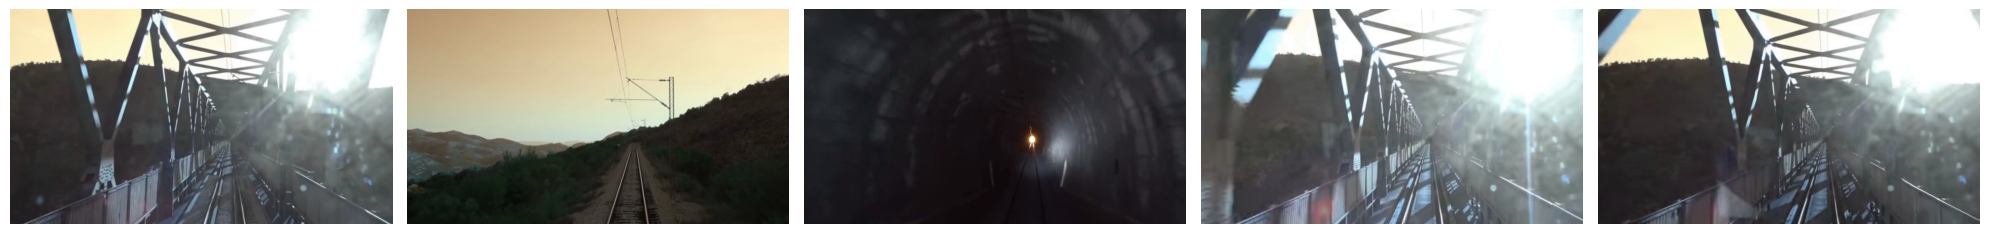

shape: (720, 1280, 3)


In [4]:
# Step 2: Preview a random sample of images

import matplotlib.pyplot as plt

# Display up to 5 frames
display_frames = frames[:5]

fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))

for ax, frame in zip(axs, display_frames):
    ax.imshow(frame)
    ax.axis('off')

plt.tight_layout()
plt.show()
print("shape:", frames[0].shape)

In [5]:
# Step 3: Split each pixel position into its respective color series
# (AKA: TVs)

def pixel_color_series(x_position, y_position):
    return frames[:, x_position, y_position]

def tv(position):
    # select a random position so that there aren't any clues about where the TV goes
    position = random_indices[position]

    # convert to an x, y position
    x_position = position % width
    y_position = position // width
    return frames[:, x_position, y_position]

tvs = []
for i in tqdm(range(number_of_tvs), desc="Flattening tvs and turning them into a list"):
    tvs.append(tv(i))

del frames # clear out the frames, because by using flatten() we have created a copy
# note: ravel() might work to return a view instead of making a copy, try this later...

Flattening tvs and turning them into a list: 100%|██████████████████████████| 10000/10000 [00:00<00:00, 1114232.13it/s]


At this point, we now have each TV stored in the list <b><i>tvs</i></b>.

We should now be applying UMAP to the TVs!

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from PIL import Image
import os

def create_som_animation(tvs, som_size=(20, 20), output_file='som_animation.gif'):
    """
    Creates an animated GIF of a SOM mapping based on a list of color lists.

    Parameters:
    - tvs: List of tvs, where each tv is a list of colors (RGB values in 0-255 range).
    - som_size: Tuple indicating the size of the SOM grid (width, height).
    - output_file: Filename for the output GIF.
    """

    som_width, som_height = som_size
    # Initialize the SOM with 3 input features (RGB)
    som = MiniSom(som_width, som_height, 20, sigma=1.0, learning_rate=0.5)
    # Randomly initialize weights
    som.random_weights_init(np.random.rand(som_width, som_height, 3))

    frames = []
    temp_dir = 'temp_frames'
    os.makedirs(temp_dir, exist_ok=True)

    # Function to normalize colors to [0, 1] range
    def normalize_colors(colors):
        return np.array(colors) / 255.0

    for idx, tv in enumerate(tvs):
        print(f'Processing tv {idx+1}/{len(tvs)}')
        colors = normalize_colors(tv)
        # Train the SOM with current tv's colors
        som.train_random(colors, num_iteration=10)

        # Get the SOM's weight vectors (colors)
        weights = som.get_weights()
        # Flip weights for correct orientation in the image
        weights = np.flipud(weights)

        # Plot the SOM grid
        plt.figure(figsize=(6, 6))
        plt.imshow(weights, interpolation='nearest')
        plt.axis('off')
        plt.tight_layout(pad=0)

        # Save the frame
        frame_path = os.path.join(temp_dir, f'frame_{idx}.png')
        plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        frames.append(Image.open(frame_path))

    # Save frames as an animated GIF
    frames[0].save(
        output_file,
        save_all=True,
        append_images=frames[1:],
        duration=300,
        loop=0
    )

    # Clean up temporary frames
    for frame in frames:
        frame.close()
    for file in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, file))
    os.rmdir(temp_dir)

    print(f'Animation saved as {output_file}')


In [11]:
create_som_animation(tvs[:number_of_tvs])

ValueError: could not broadcast input array from shape (20,3) into shape (20,)